## Homework 2

### Jaewon Son / 2163284

---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

---

#### **Q1. K-Nearest-Neighbor Classification on Newsgroups**

##### Q1.a
1. Download the data set and load it including the train and test matrices as well as the labels.
2. Show the top 20 terms in the decreasing order of total training frequency.
3. Plot the distribution of term frequencies in the training data.

In [2]:
# Define file path
modified_terms_file_path = ("C:\\Users\wodnj\\OneDrive\\바탕 화면\\Programming Machine Learning Applications\\DSC 478 - Week 3\\Data File\\modifiedterms.txt")
train_classes_file_path = ("C:\\Users\wodnj\\OneDrive\\바탕 화면\\Programming Machine Learning Applications\\DSC 478 - Week 3\\Data File\\trainClasses.txt")
test_classes_file_path = ("C:\\Users\wodnj\\OneDrive\\바탕 화면\\Programming Machine Learning Applications\\DSC 478 - Week 3\\Data File\\testClasses.txt")
train_matrix_modified_file_path = ("C:\\Users\wodnj\\OneDrive\\바탕 화면\\Programming Machine Learning Applications\\DSC 478 - Week 3\\Data File\\trainMatrixModified.txt")
test_matrix_modified_file_path = ("C:\\Users\wodnj\\OneDrive\\바탕 화면\\Programming Machine Learning Applications\\DSC 478 - Week 3\\Data File\\testMatrixModified.txt")

# Load the modified terms
with open(modified_terms_file_path, 'r') as f:
    modified_terms = [line.strip() for line in f]

# Load the train and test labels
train_label = np.loadtxt(train_classes_file_path, usecols = 1, dtype = int) 
test_label = np.loadtxt(test_classes_file_path, usecols = 1, dtype = int) 

# Load the train and test matrices
train_matrix = np.loadtxt(train_matrix_modified_file_path).T
test_matrix = np.loadtxt(test_matrix_modified_file_path).T

# Display shapes
print("Number of Modified Terms:", len(modified_terms))
print("Train Labels Shape:", train_label.shape)
print("Test Labels Shape:", test_label.shape)
print("Train Matrix Shape:", train_matrix.shape)
print("Test Matrix Shape:", test_matrix.shape)

Number of Modified Terms: 5501
Train Labels Shape: (800,)
Test Labels Shape: (200,)
Train Matrix Shape: (800, 5500)
Test Matrix Shape: (200, 5500)


In [3]:
summed_term_frequency_from_train_matrix = np.sum(train_matrix, axis = 0) # Sum the frequency across all documents
sorted_summed_term_frequency_from_train_matrix = np.argsort(summed_term_frequency_from_train_matrix)[::-1] # Sort in descending order

# Get the top 20 terms and their frequencies
top_20_indices = sorted_summed_term_frequency_from_train_matrix[:20]
top_20_terms = [modified_terms[i] for i in top_20_indices]
top_20_frequencies = summed_term_frequency_from_train_matrix[top_20_indices]

print("Top 20 terms of total frequency from the train matrix:")
for term, freqency in zip(top_20_terms, top_20_frequencies):
    print(f"Term: {term}, Frequency: {int(freqency)}")

Top 20 terms of total frequency from the train matrix:
Term: subject, Frequency: 959
Term: window, Frequency: 720
Term: game, Frequency: 680
Term: do, Frequency: 578
Term: get, Frequency: 545
Term: write, Frequency: 483
Term: team, Frequency: 470
Term: on, Frequency: 429
Term: plai, Frequency: 401
Term: go, Frequency: 378
Term: file, Frequency: 370
Term: program, Frequency: 329
Term: includ, Frequency: 326
Term: just, Frequency: 325
Term: player, Frequency: 323
Term: articl, Frequency: 319
Term: time, Frequency: 318
Term: hockei, Frequency: 311
Term: know, Frequency: 302
Term: year, Frequency: 300


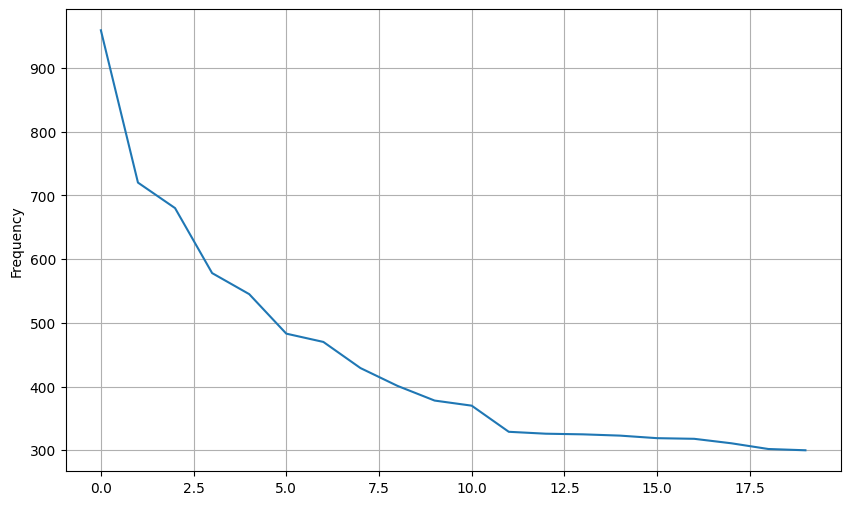

In [4]:
# Plot the distribution of term frequencies
plt.figure(figsize = (10, 6))
plt.plot(top_20_frequencies)
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

---

##### Q1.b
1. Create K-Nearest-Neighor classifier function.
2. Show the classifier works by running it on the first two instances in the testing data.

In [5]:
def knn_classifier(train_matrix, train_label, test_matrix, number_of_neighbors, distance_metric):

    """
    KNN classifier that classifies an instance based on its K nearest neighbors.
     
    Parameters:
    - train_matrix: The matrix of training data
    - train_label: The array of class labels corresponding to the training data
    - test_matrix: The instance to be classified
    - number_of_neighbors: The number of neighbors
    - distance_metric: The distance metric to use for finding nearest neighbors (Euclidean, Cosine, Manhattan, Pearson)

    Returns:
    - predicted_class: The predicted class label based on the majority vote from the KNN 
    - top_k_indices : The indices of the top K neighbors 
    """
    
    # Calculate Euclidean distance
    if distance_metric == 'euclidean': 
        distances = np.sqrt(((train_matrix - test_matrix) ** 2).sum(axis = 1))

    # Calculate Cosine distance
    elif distance_metric == 'cosine': 
        train_matrix_norm = np.array([np.linalg.norm(train_matrix[i]) for i in range(len(train_matrix))]) # Compute the norms of each instance
        test_instance_norm = np.linalg.norm(test_matrix) # Compute the norm of the instance
        cosine_similarity = np.dot(train_matrix, test_matrix) / (train_matrix_norm * test_instance_norm) # Compute Cosine Similarity
        distances = 1 - cosine_similarity # Convert Cosine Similarity to distance
    
    # Calculate Manhattan distance
    elif distance_metric == 'manhattan': 
        distances = np.sum(np.abs(train_matrix - test_matrix), axis = 1)

    # Calculate Pearson distance
    elif distance_metric == 'pearson':
        distances = np.array([1 - np.corrcoef(test_matrix, train_vector)[0, 1] for train_vector in train_matrix])

    # Get the indices of the sorted distances
    top_k_indices = np.argsort(distances)[:number_of_neighbors]

    # Get the labels of the top K neighbors
    top_k_labels = train_label[top_k_indices]
    predicted_class = np.bincount(top_k_labels).argmax() # Predict the class
    
    return predicted_class, top_k_indices

In [6]:
predicted_class, top_k_indices = knn_classifier(train_matrix, train_label, test_matrix[0], 5, 'euclidean')
print(f"Predicted Class: {predicted_class}")
print(f"Top K Neighbors Indices: {top_k_indices}")
print("")

predicted_class, top_k_indices = knn_classifier(train_matrix, train_label, test_matrix[0], 5, 'cosine')
print(f"Predicted Class: {predicted_class}")
print(f"Top K Neighbors Indices: {top_k_indices}")
print("")

predicted_class, top_k_indices = knn_classifier(train_matrix, train_label, test_matrix[0], 5, 'manhattan')
print(f"Predicted Class: {predicted_class}")
print(f"Top K Neighbors Indices: {top_k_indices}")
print("")

predicted_class, top_k_indices = knn_classifier(train_matrix, train_label, test_matrix[0], 5, 'pearson')
print(f"Predicted Class: {predicted_class}")
print(f"Top K Neighbors Indices: {top_k_indices}")
print("")

print("-----------------------------------------------")
print("")

predicted_class, top_k_indices = knn_classifier(train_matrix, train_label, test_matrix[1], 5, 'euclidean')
print(f"Predicted Class: {predicted_class}")
print(f"Top K Neighbors Indices: {top_k_indices}")
print("")

predicted_class, top_k_indices = knn_classifier(train_matrix, train_label, test_matrix[1], 5, 'cosine')
print(f"Predicted Class: {predicted_class}")
print(f"Top K Neighbors Indices: {top_k_indices}")
print("")

predicted_class, top_k_indices = knn_classifier(train_matrix, train_label, test_matrix[1], 5, 'manhattan')
print(f"Predicted Class: {predicted_class}")
print(f"Top K Neighbors Indices: {top_k_indices}")
print("")

predicted_class, top_k_indices = knn_classifier(train_matrix, train_label, test_matrix[1], 5, 'pearson')
print(f"Predicted Class: {predicted_class}")
print(f"Top K Neighbors Indices: {top_k_indices}")

Predicted Class: 1
Top K Neighbors Indices: [685 628 703 266 510]

Predicted Class: 1
Top K Neighbors Indices: [685 628 667 152 427]

Predicted Class: 1
Top K Neighbors Indices: [685 798 703 757  38]

Predicted Class: 1
Top K Neighbors Indices: [685 628 667 152 427]

-----------------------------------------------

Predicted Class: 0
Top K Neighbors Indices: [798 554 757 224  38]

Predicted Class: 0
Top K Neighbors Indices: [382 775 163 587 550]

Predicted Class: 0
Top K Neighbors Indices: [798 757 224  38 342]

Predicted Class: 0
Top K Neighbors Indices: [382 775 163 587 550]


---

##### Q1.c
1. Create an evaluation function to measure the accuracy of your classifier.

In [7]:
def evaluate_knn_classifier(train_matrix, train_label, test_matrix, test_label, number_of_neighbors, distance_metric):
    
    """
    Evaluate the KNN classifier on test instances and calculate the accuracy.

    Parameters:
    - train_matrix: The matrix of training data
    - train_label: The array of class labels corresponding to the training data
    - test_matrix: The matrix of testing data
    - test_label: The array of class labels corresponding to the testing data
    - number_of_neighbors: The number of neighbors
    - distance_metric: The distance metric to use for finding nearest neighbors (Euclidean, Cosine, Manhattan, Pearson)
    
    Returns:
    - accuracy: The classification accuracy
    """

    error_count = 0 # Initialize error count
    number_of_test_instance = test_matrix.shape[0] # Get the total number of test instance

    for i in range(number_of_test_instance):

        test_instance = test_matrix[i]
        true_label = test_label[i]

        # Call the KNN classifier to predict the class
        predicted_class, _ = knn_classifier(train_matrix, train_label, test_instance, number_of_neighbors, distance_metric)

        # Compare predicted class with true label
        if predicted_class != true_label:
            error_count += 1

    # Calculate accuracy
    accuracy = 1 - (error_count / number_of_test_instance)

    return accuracy

In [8]:
accuracy_euclidean = evaluate_knn_classifier(train_matrix, train_label, test_matrix, test_label, 5, 'euclidean')
print(f"Classification Accuracy with Euclidean Distance Matrix: {accuracy_euclidean:.4f}")
print()

accuracy_cosine = evaluate_knn_classifier(train_matrix, train_label, test_matrix, test_label, 5, 'cosine')
print(f"Classification Accuracy with Cosine Distance Matrix: {accuracy_cosine:.4f}")
print()

accuracy_manhattan = evaluate_knn_classifier(train_matrix, train_label, test_matrix, test_label, 5, 'manhattan')
print(f"Classification Accuracy with Manhattan Distance Matrix: {accuracy_manhattan:.4f}")
print()

accuracy_pearson = evaluate_knn_classifier(train_matrix, train_label, test_matrix, test_label, 5, 'pearson')
print(f"Classification Accuracy with Pearson Distance Matrix: {accuracy_pearson:.4f}")

Classification Accuracy with Euclidean Distance Matrix: 0.8150

Classification Accuracy with Cosine Distance Matrix: 0.9700

Classification Accuracy with Manhattan Distance Matrix: 0.6550

Classification Accuracy with Pearson Distance Matrix: 0.9700


---

##### Q1.d
1. Run the evaluation function on a range of values for K from 5 to 100 in increments of 5 in order to compare accuracy values for different numbers of neighbors.
2. Present the results using a single plot to compare the four versions of the classifiers.

In [9]:
# Evaluate the KNN classifier for K values ranging from 5 to 100 with Euclidean Distance Matrix
accuracy_euclidean_list = []
for K in range(5, 101, 5):
    accuracy_euclidean_list.append(evaluate_knn_classifier(train_matrix, train_label, test_matrix, test_label, K, 'euclidean'))

# Evaluate the KNN classifier for K values ranging from 5 to 100 with Cosine Distance Matrix
accuracy_cosine_list = []
for K in range(5, 101, 5):
    accuracy_cosine_list.append(evaluate_knn_classifier(train_matrix, train_label, test_matrix, test_label, K, 'cosine'))

# Evaluate the KNN classifier for K values ranging from 5 to 100 with Manhattan Distance Matrix
accuracy_manhattan_list = []
for K in range(5, 101, 5):
    accuracy_manhattan_list.append(evaluate_knn_classifier(train_matrix, train_label, test_matrix, test_label, K, 'manhattan'))

# Evaluate the KNN classifier for K values ranging from 5 to 100 with Pearson Distance Matrix
accuracy_pearson_list = []
for K in range(5, 101, 5):
    accuracy_pearson_list.append(evaluate_knn_classifier(train_matrix, train_label, test_matrix, test_label, K, 'pearson'))

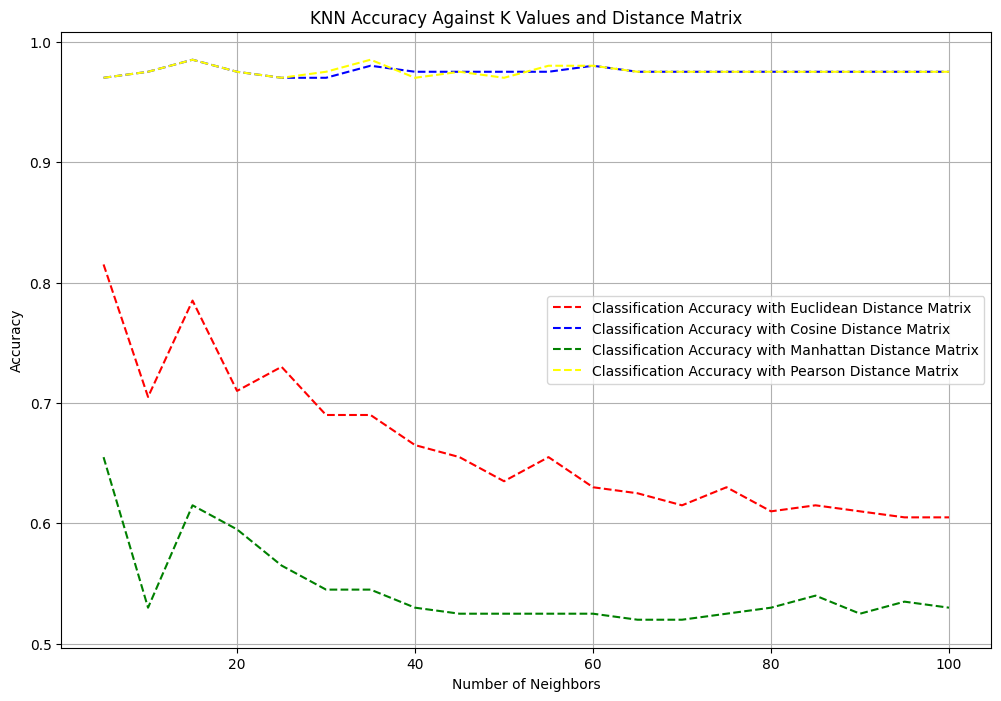

In [10]:
# Plot the KNN classifier accuracy against K values and weights
k_values = list(range(5, 101, 5))
plt.figure(figsize = (12, 8))
plt.plot(k_values, accuracy_euclidean_list, label = 'Classification Accuracy with Euclidean Distance Matrix', color = 'red', linestyle = '--')
plt.plot(k_values, accuracy_cosine_list, label = 'Classification Accuracy with Cosine Distance Matrix', color = 'blue', linestyle = '--')
plt.plot(k_values, accuracy_manhattan_list, label = 'Classification Accuracy with Manhattan Distance Matrix', color = 'green', linestyle = '--')
plt.plot(k_values, accuracy_pearson_list, label = 'Classification Accuracy with Pearson Distance Matrix', color = 'yellow', linestyle = '--')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy Against K Values and Distance Matrix')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

---

##### Q1.e
1. Modify the training and testing sets so that term weights are converted to TF-IDF weights.
2. Rerun evaluation only for the Cosine similarity version on the range of K values.
3. Create a chart comparing the results with and without using TF-IDF weights.

In [11]:
# Transform to TF-IDF weights
tfidf_transformer = TfidfTransformer()
train_matrix_tfidf = tfidf_transformer.fit_transform(train_matrix).toarray()
test_matrix_tfidf = tfidf_transformer.transform(test_matrix).toarray()

In [12]:
# Evaluate the KNN classifier for K values ranging from 5 to 100 with Cosine Distance Matrix
tfidf_accuracy_cosine_list = []
for K in range(5, 101, 5):
    tfidf_accuracy_cosine_list.append(evaluate_knn_classifier(train_matrix_tfidf, train_label, test_matrix_tfidf, test_label, K, 'cosine'))

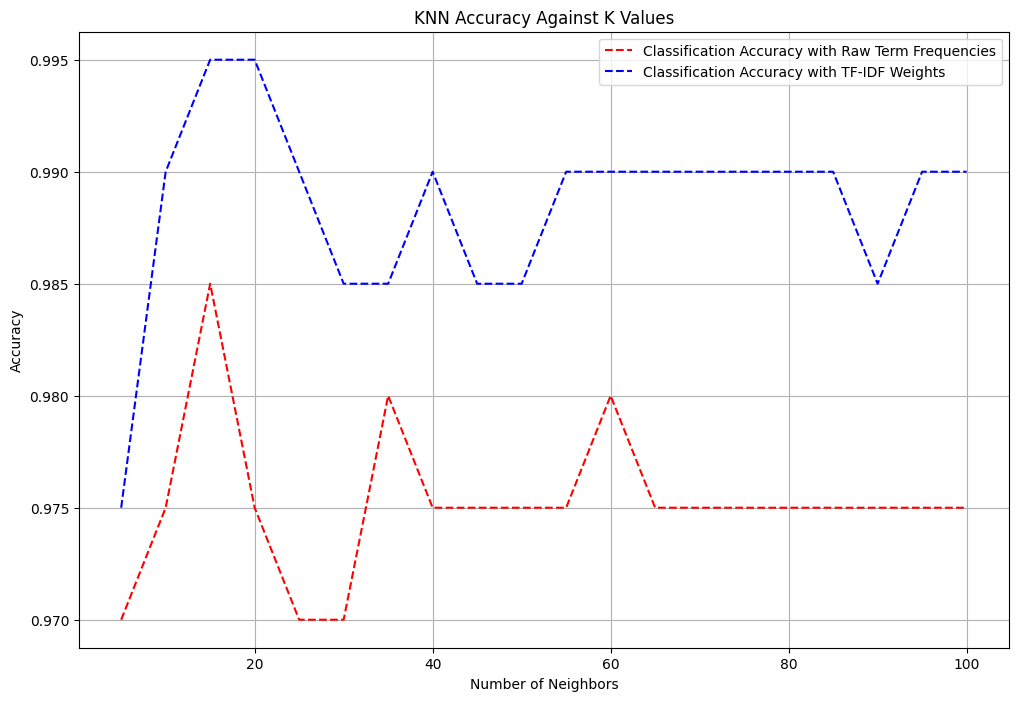

In [13]:
# Plot the KNN classifier accuracy against K values
k_values = list(range(5, 101, 5))
plt.figure(figsize = (12, 8))
plt.plot(k_values, accuracy_cosine_list, label = 'Classification Accuracy with Raw Term Frequencies', color = 'red', linestyle = '--')
plt.plot(k_values, tfidf_accuracy_cosine_list, label = 'Classification Accuracy with TF-IDF Weights', color = 'blue', linestyle = '--')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy Against K Values')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

---

##### Q1.f
1. Create a new classifier based on the Rocchio Method adapted for text categorization.
2. Using the evaluation function, compare results to those obtained in Q1.d.

In [14]:
def rocchio_training(train_matrix, train_labels):

    # Find the unique class labels
    classes = np.unique(train_labels) 
    
    # Dictionary to store the prototype for each class
    prototypes = {} 
    
    for class_label in classes:
        class_vectors = train_matrix[train_labels == class_label] # Select rows corresponding to the current class
        prototypes[class_label] = np.mean(class_vectors, axis = 0) # Calculate the centroid by averaging the vectors for each class
    
    return prototypes

In [15]:
def rocchio_classification(prototypes, test_matrix):
    
    # Dictionary to store similarity values for each class
    similarity_value = {} 
    
    # Reshape the test matrix to a 2D array with 1 row
    test_matrix = test_matrix.reshape(1, -1)
    
    for class_label, prototype in prototypes.items():
        prototype = prototype.reshape(1, -1) # Reshape the prototype to a 2D array with 1 row
        similarity_value[class_label] = cosine_similarity(test_matrix, prototype) # Compute the cosine similarity for each class
    
    predicted_class = max(similarity_value, key = similarity_value.get) # Find the class with the highest similarity score
    
    return predicted_class, similarity_value


In [16]:
def rocchio_evaluation(rocchio_classification, test_matrix, test_label, prototypes):

    error_count = 0 # Initialize error count
    number_of_test_label = len(test_label) # Get the total number of test label
    
    for i in range(number_of_test_label):
        predicted_class, similarities = rocchio_classification(prototypes, test_matrix[i])
        true_class = test_label[i]
        
        if predicted_class != true_class:
            error_count += 1
    
    accuracy_rocchio = 1 - (error_count / number_of_test_label)

    return accuracy_rocchio

In [17]:
prototypes = rocchio_training(train_matrix, train_label) # Train the Rocchio classifier
accuracy_rocchio = rocchio_evaluation(rocchio_classification, test_matrix, test_label, prototypes) # Evaluate the Rocchio classifier

print(f"Classification Accuracy with Rocchio Method: {accuracy_rocchio:.4f}")

Classification Accuracy with Rocchio Method: 0.9750


---

##### Q1.g
1. Using scikit-learn's Nearest Centroid classifier to perform classification of the test instances.
2. Compare the classification accuracy of Rocchio's implementation to the classification results using scikit-learn.

In [18]:
def nearest_centroid(train_matrix, train_label, test_matrix, test_label):
    
    # Initialize the classifier
    nc_classifier = NearestCentroid(metric = 'cosine') 
    
    # Fit the classifier
    nc_classifier.fit(train_matrix, train_label)
    
    # Predict the labels
    nc_test_prediction = nc_classifier.predict(test_matrix)
    
    # Compute the accuracy of the classifier
    accuracy_nearest_centroid = accuracy_score(test_label, nc_test_prediction)

    return accuracy_nearest_centroid

In [19]:
accuracy_nearest_centroid = nearest_centroid(train_matrix, train_label, test_matrix, test_label)

print(f"Classification Accuracy with Rocchio Method: {accuracy_rocchio:.4f}")
print(f"Classification Accuracy with scikit-learn's Rocchio Method: {accuracy_nearest_centroid:.4f}")

Classification Accuracy with Rocchio Method: 0.9750
Classification Accuracy with scikit-learn's Rocchio Method: 0.9750


c:\Users\wodnj\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
c:\Users\wodnj\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


---

#### **Q2. Predictive Modeling with Census Data**

##### Q2.a
1. Load the data into a Pandas data frame.
2. Create dummy variables only if necessary for the categorical attributes.
3. Split the transformed data into training and testing sets

In [20]:
wine = load_wine() # Load the wine dataset
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names) # Convert to a DataFrame

In [21]:
df_wine['target'] = wine.target # Add the target variable
target_names = {i: name for i, name in enumerate(wine.target_names)} # Create a mapping of target values to wine class names
df_wine['class'] = df_wine['target'].map(target_names) # Map the numeric target values to their corresponding class names
df_wine_target = df_wine['target']
display(df_wine_target)

0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: target, Length: 178, dtype: int32

In [22]:
# Drop unnecessary columns 
df_wine = df_wine.drop(columns = ['class', 'target'])
display(df_wine)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [23]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df_wine, df_wine_target, test_size = 0.2, random_state = 111)

print("Training Features:\n", x_train.head(3))
print("\nTesting Features:\n", x_test.head(3))
print("\nTraining Target:\n", y_train.head(3))
print("\nTesting Target:\n", y_test.head(3))

Training Features:
      alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
24     13.50        1.81  2.61               20.0       96.0           2.53   
113    11.41        0.74  2.50               21.0       88.0           2.48   
138    13.49        3.59  2.19               19.5       88.0           1.62   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
24         2.61                  0.28             1.66             3.52  1.12   
113        2.01                  0.42             1.44             3.08  1.10   
138        0.48                  0.58             0.88             5.70  0.81   

     od280/od315_of_diluted_wines  proline  
24                           3.82    845.0  
113                          2.31    434.0  
138                          1.82    580.0  

Testing Features:
      alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
129    12.04        4.30  2.38               22.0       80.

---

##### Q2.b-1
1. Normalize the data.
2. Run KNN classifier using K = 10.
3. Generate the confusion matrix as well as the classification report.
4. Report the model accuracy for both the training and testing sets.

In [24]:
# Normalize the data to scale features between 0 and 1
x_train_normalized = MinMaxScaler().fit_transform(x_train)
x_test_normalized = MinMaxScaler().fit_transform(x_test)

In [25]:
# Initialize the classifier
knn_classifier = KNeighborsClassifier(n_neighbors = 10)

# Fit the classifier
knn_classifier.fit(x_train_normalized, y_train)

# Predict the labels
knn_train_prediction = knn_classifier.predict(x_train_normalized) 
knn_test_prediction = knn_classifier.predict(x_test_normalized)

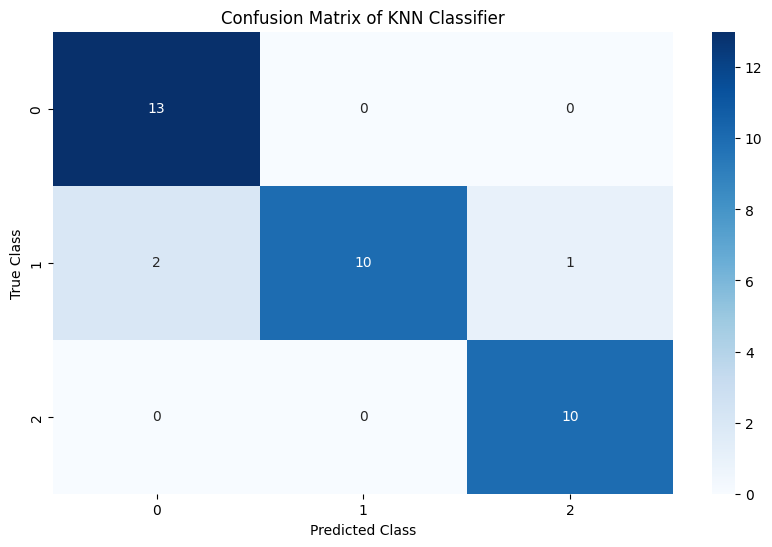

In [26]:
# Plot the confusion matrix
knn_confusion_matrix = confusion_matrix(y_test, knn_test_prediction)
plt.figure(figsize = (10, 6))
sns.heatmap(knn_confusion_matrix, annot = True, cmap = 'Blues')
plt.title("Confusion Matrix of KNN Classifier")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [27]:
# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, knn_test_prediction))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.77      0.87        13
           2       0.91      1.00      0.95        10

    accuracy                           0.92        36
   macro avg       0.93      0.92      0.92        36
weighted avg       0.93      0.92      0.91        36



In [28]:
# Evaluate the model accuracy
knn_train_accuracy = accuracy_score(y_train, knn_train_prediction)
knn_test_accuracy = accuracy_score(y_test, knn_test_prediction)

print(f"Training Accuracy of the KNN Classifier: {knn_train_accuracy:.4f}")
print(f"Testing Accuracy of the KNN Classifier: {knn_test_accuracy:.4f}")

Training Accuracy of the KNN Classifier: 0.9648
Testing Accuracy of the KNN Classifier: 0.9167


---

##### Q2.b-2
1. Experiment with different values of K and the weight parameter to improve the accuracy of the KNN classifier. 
2. Show the results in a single plot comparing distance and uniform weighting schemes across the different values of K.
3. Use the best values of these parameters to train a new KNN classifier.
4. Report the accuracy of this classifier on the training and testing sets.

In [29]:
knn_train_accuracy_uniform_weight_list = []
knn_test_accuracy_uniform_weight_list = []

for k in range(5, 101):

    # Initialize the classifier with 'uniform' weight
    knn_classifier_uniform_weight = KNeighborsClassifier(n_neighbors = k, weights = 'uniform')
    
    # Fit the classifier
    knn_classifier_uniform_weight.fit(x_train_normalized, y_train)

    # Predict the labels
    knn_train_prediction_uniform_weight = knn_classifier_uniform_weight.predict(x_train_normalized)
    knn_test_prediction_uniform_weight = knn_classifier_uniform_weight.predict(x_test_normalized)

    # Calculate the accuracy and store to the lists
    knn_train_accuracy_uniform_weight_list.append(accuracy_score(y_train, knn_train_prediction_uniform_weight))
    knn_test_accuracy_uniform_weight_list.append(accuracy_score(y_test, knn_test_prediction_uniform_weight))

c:\Users\wodnj\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\wodnj\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [30]:
knn_train_accuracy_distance_weight_list = []
knn_test_accuracy_distance_weight_list = []

for k in range(5, 101):

    # Initialize the classifier with 'distance' weight
    knn_classifier_distance_weight = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
    
    # Fit the classifier
    knn_classifier_distance_weight.fit(x_train_normalized, y_train)

    # Predict the labels
    knn_train_prediction_distance_weight = knn_classifier_distance_weight.predict(x_train_normalized)
    knn_test_prediction_distance_weight = knn_classifier_distance_weight.predict(x_test_normalized)

    # Calculate the accuracy and store to the lists
    knn_train_accuracy_distance_weight_list.append(accuracy_score(y_train, knn_train_prediction_distance_weight))
    knn_test_accuracy_distance_weight_list.append(accuracy_score(y_test, knn_test_prediction_distance_weight))

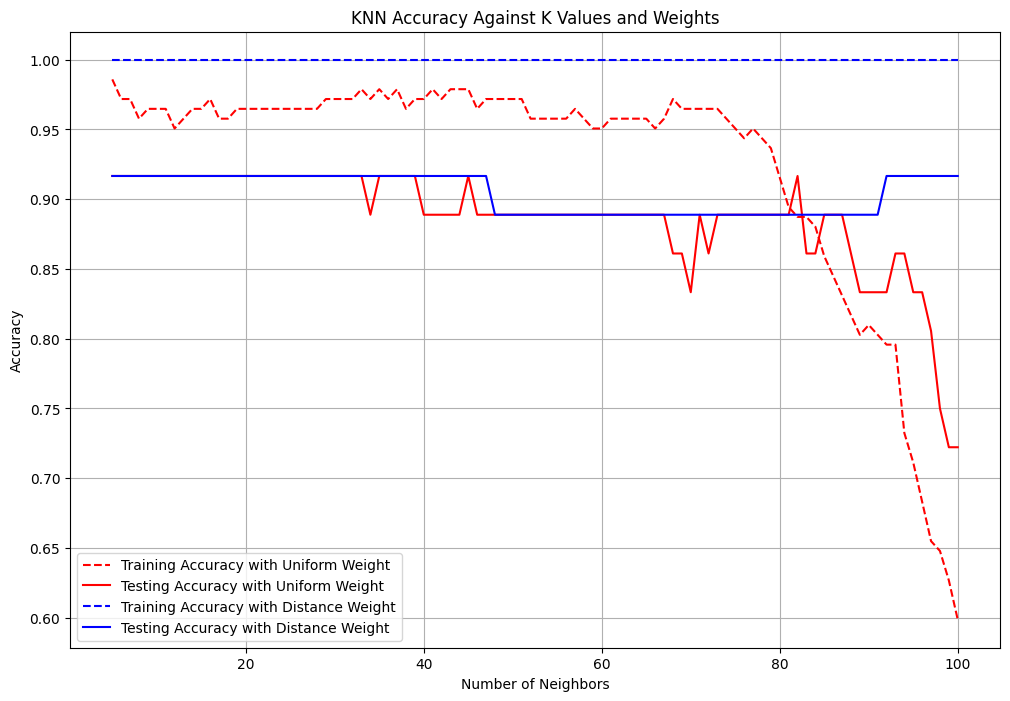

In [31]:
# Plot the KNN classifier accuracy against K values and weights
k_values = list(range(5, 101))
plt.figure(figsize = (12, 8))
plt.plot(k_values, knn_train_accuracy_uniform_weight_list, label = 'Training Accuracy with Uniform Weight', color = 'red', linestyle = '--')
plt.plot(k_values, knn_test_accuracy_uniform_weight_list, label = 'Testing Accuracy with Uniform Weight', color = 'red', linestyle = '-')
plt.plot(k_values, knn_train_accuracy_distance_weight_list, label = 'Training Accuracy with Distance Weight', color = 'blue', linestyle = '--')
plt.plot(k_values, knn_test_accuracy_distance_weight_list, label = 'Testing Accuracy with Distance Weight', color = 'blue', linestyle = '-')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy Against K Values and Weights')
plt.legend(loc = 'lower left')
plt.grid(True)
plt.show()

In [32]:
# Initialize the classifier with the best values of parameters
best_knn_classifier = KNeighborsClassifier(n_neighbors = 12, weights = 'uniform')

# Fit the classifier
best_knn_classifier.fit(x_train_normalized, y_train)

# Predict the labels
best_knn_train_prediction = best_knn_classifier.predict(x_train_normalized)
best_knn_test_prediction = best_knn_classifier.predict(x_test_normalized)

# Evaluate the model accuracy
best_knn_train_accuracy = accuracy_score(y_train, best_knn_train_prediction)
best_knn_test_accuracy = accuracy_score(y_test, best_knn_test_prediction)

print(f"Training Accuracy of the KNN Classifier: {best_knn_train_accuracy:.4f}")
print(f"Testing Accuracy of the KNN Classifier: {best_knn_test_accuracy:.4f}")

Training Accuracy of the KNN Classifier: 0.9507
Testing Accuracy of the KNN Classifier: 0.9167


---

##### Q2.b-3
1. Using only "uniform" weights, compare the accuracy of the KNN classifier across the different values of K on the training and testing sets. 
2. Show the results in a single figure with two-line plots for the training and testing accuracy values in the y-axis and with values of K in the x-axis.
3. Briefly explain what range of values of K represents overfitting.

In [33]:
knn_train_accuracy_uniform_weight_list = []
knn_test_accuracy_uniform_weight_list = []

for k in range(5, 101):

    # Initialize the classifier with 'uniform' weight
    knn_classifier_uniform_weight = KNeighborsClassifier(n_neighbors = k, weights = 'uniform')
    
    # Fit the classifier
    knn_classifier_uniform_weight.fit(x_train_normalized, y_train)

    # Predict the labels
    knn_train_prediction_uniform_weight = knn_classifier_uniform_weight.predict(x_train_normalized)
    knn_test_prediction_uniform_weight = knn_classifier_uniform_weight.predict(x_test_normalized)

    # Calculate the accuracy and store to the lists
    knn_train_accuracy_uniform_weight_list.append(accuracy_score(y_train, knn_train_prediction_uniform_weight))
    knn_test_accuracy_uniform_weight_list.append(accuracy_score(y_test, knn_test_prediction_uniform_weight))

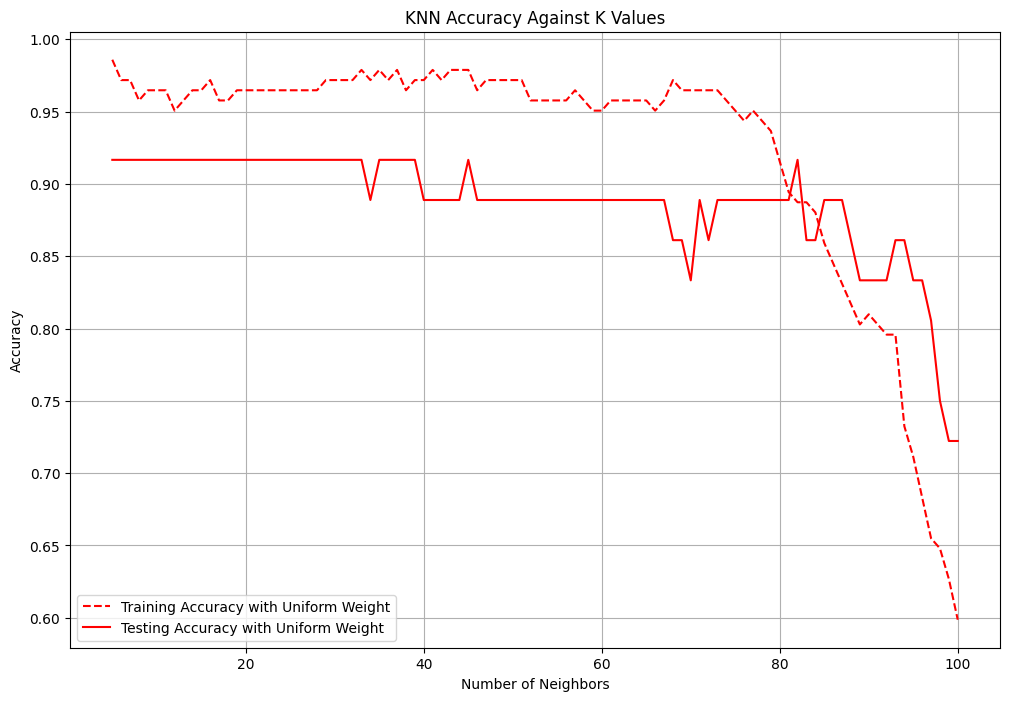

In [34]:
# Plot the KNN classifier accuracy against K values
k_values = list(range(5, 101))
plt.figure(figsize = (12, 8))
plt.plot(k_values, knn_train_accuracy_uniform_weight_list, label = 'Training Accuracy with Uniform Weight', color = 'red', linestyle = '--')
plt.plot(k_values, knn_test_accuracy_uniform_weight_list, label = 'Testing Accuracy with Uniform Weight', color = 'red', linestyle = '-')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy Against K Values')
plt.legend(loc = 'lower left')
plt.grid(True)
plt.show()

Approximately, overfitting in this KNN classifier is observed when the value of K is less than 7 or falls within the range of 20 to 80.

---

##### Q2.c
1. Using the non-normalized training and testing data, perform classification using scikit-learn's decision tree classifier.
2. Generate the confusion matrix, classification report, and average accuracy scores of the classifier.
3. Compare the average accuracy score on the training and testing data sets.
4. Explain What does the comparison tell in terms of bias-variance trade-off.
5. Create another decision tree model using "gini" index, min_samples_split = 10, and max_depth = 4. 
6. Show the accuracy results for both the training and testing sets.
7. Generate a visualization of a tree embedded in the Jupyter Notebook.

In [35]:
# Initialize the classifier
dt_classifier = DecisionTreeClassifier()

# Fit the classifier
dt_classifier.fit(x_train, y_train)

# Predict the labels
dt_train_prediction = dt_classifier.predict(x_train)
dt_test_prediction = dt_classifier.predict(x_test)

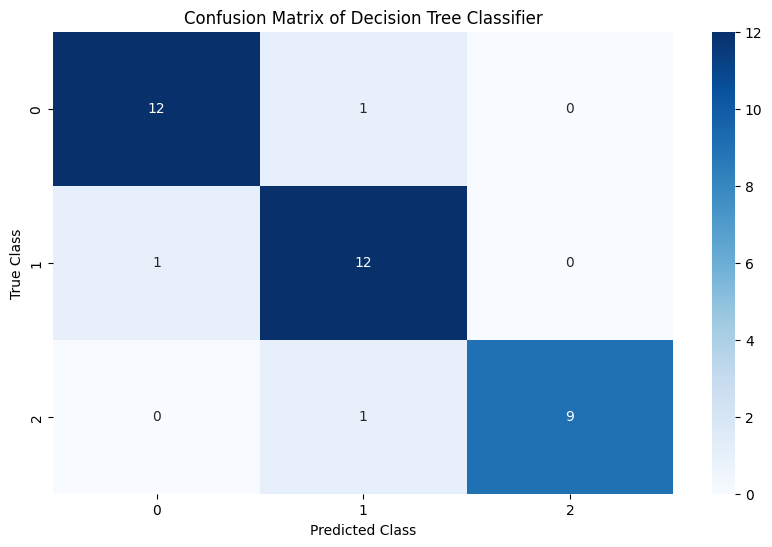

In [36]:
# Plot the confusion matrix
dt_confusion_matrix = confusion_matrix(y_test, dt_test_prediction)
plt.figure(figsize = (10, 6))
sns.heatmap(dt_confusion_matrix, annot = True, cmap = 'Blues')
plt.title("Confusion Matrix of Decision Tree Classifier")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [37]:
# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, dt_test_prediction))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.86      0.92      0.89        13
           2       1.00      0.90      0.95        10

    accuracy                           0.92        36
   macro avg       0.93      0.92      0.92        36
weighted avg       0.92      0.92      0.92        36



In [38]:
# Evaluate the model accuracy
dt_train_accuracy = accuracy_score(y_train, dt_train_prediction)
dt_test_accuracy = accuracy_score(y_test, dt_test_prediction)

print(f"Training Accuracy of the KNN Classifier: {dt_train_accuracy:.4f}")
print(f"Testing Accuracy of the KNN Classifier: {dt_test_accuracy:.4f}")

Training Accuracy of the KNN Classifier: 1.0000
Testing Accuracy of the KNN Classifier: 0.9167


The training accuracy from this classifier indicates that the model fits the training data perfectly. This suggests a low bias and high variance due to overfitting. On the other hand, the lower testing accuracy shows that this classifier doesn't work effectively on the unseen data as much as it does on the training set. To improve generalization, it is necessary to consider reducing the number of neighbors, increasing the size of the training dataset, etc.

In [39]:
# Initialize the classifier with given parameters
dt_classifier_gini_criterion = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 10, max_depth = 4)

# Fit the classifier
dt_classifier_gini_criterion.fit(x_train, y_train)

# Predict the labels
dt_train_prediction_gini_criterion = dt_classifier_gini_criterion.predict(x_train)
dt_test_prediction_gini_criterion = dt_classifier_gini_criterion.predict(x_test)

# Evaluate the model accuracy
dt_train_accuracy_gini_criterion = accuracy_score(y_train, dt_train_prediction_gini_criterion)
dt_test_accuracy_gini_criterion = accuracy_score(y_test, dt_test_prediction_gini_criterion)

print(f"Training Accuracy of the KNN Classifier: {dt_train_accuracy_gini_criterion:.4f}")
print(f"Testing Accuracy of the KNN Classifier: {dt_test_accuracy_gini_criterion:.4f}")

Training Accuracy of the KNN Classifier: 1.0000
Testing Accuracy of the KNN Classifier: 0.9167


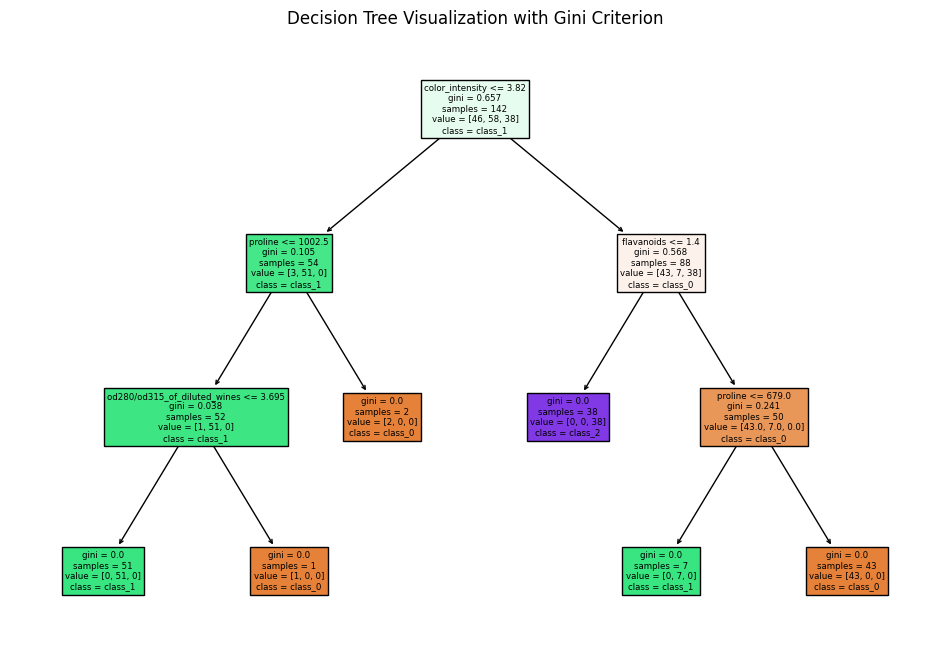

In [40]:
# Visualize the Decision Tree classifier
plt.figure(figsize = (12, 8))
tree.plot_tree(dt_classifier_gini_criterion, filled = True, feature_names = wine.feature_names, class_names = wine.target_names)
plt.title("Decision Tree Visualization with Gini Criterion")
plt.show()

---

##### Q2.d
1. Use scikit-learn to build classifiers using Naive Bayes and Linear Discriminant Analysis.
2. For each of these perform 10-fold cross-validation on the 80% training data and report the overall average accuracy.
3. Compare this cross-validation accuracy to the model accuracy on the training data as a whole
4. Run your model on the set-aside 20% testing data

In [41]:
# Initialize the classifier
nb_classifier = GaussianNB()

# Perform 10-fold cross-validation on the 80% training data
nb_cross_validation_score = cross_val_score(nb_classifier, x_train_normalized, y_train, cv = 10)

# Fit the classifier on the entire training data
nb_classifier.fit(x_train_normalized, y_train)

# Predict the labels
nb_train_prediction = nb_classifier.predict(x_train_normalized)

# Evaluate the model accuracy
nb_train_accuracy = accuracy_score(y_train, nb_train_prediction)

print(f"Training Accuracy of the Naive Bayes Classifier with 10-fold cross-validation: {nb_cross_validation_score.mean():.4f}")
print(f"Training Accuracy of the Naive Bayes Classifier: {nb_train_accuracy:.4f}")

Training Accuracy of the Naive Bayes Classifier with 10-fold cross-validation: 0.9929
Training Accuracy of the Naive Bayes Classifier: 1.0000


In [42]:
# Initialize the classifier
lda_classifier = LinearDiscriminantAnalysis()

# Perform 10-fold cross-validation on the 80% training data
lda_cross_validation_score = cross_val_score(lda_classifier, x_train_normalized, y_train, cv = 10)

# Fit the classifier on the entire training data
lda_classifier.fit(x_train_normalized, y_train)

# Predict the labels on the training set
lda_train_prediction = lda_classifier.predict(x_train_normalized)

# Evaluate the model accuracy
lda_train_accuracy = accuracy_score(y_train, lda_train_prediction)

print(f"Training Accuracy of the Linear Discriminant Analysis Classifier with 10-fold cross-validation: {lda_cross_validation_score.mean():.4f}")
print(f"Training Accuracy of the Linear Discriminant Analysis Classifier: {lda_train_accuracy:.4f}")

Training Accuracy of the Linear Discriminant Analysis Classifier with 10-fold cross-validation: 0.9933
Training Accuracy of the Linear Discriminant Analysis Classifier: 1.0000


In [43]:
# Predict the labels on the testing set
nb_test_prediction = nb_classifier.predict(x_test_normalized)
lda_test_prediction = lda_classifier.predict(x_test_normalized)

# Evaluate the model accuracy
nb_test_accuracy = accuracy_score(y_test, nb_test_prediction)
lda_test_accuracy = accuracy_score(y_test, lda_test_prediction)

print(f"Testing Accuracy of the Naive Bayes Classifier: {nb_test_accuracy:.4f}")
print(f"Testing Accuracy of the Linear Discriminant Analysis Classifier: {lda_test_accuracy:.4f}")


Testing Accuracy of the Naive Bayes Classifier: 0.9444
Testing Accuracy of the Linear Discriminant Analysis Classifier: 0.9444


---